<a href="https://colab.research.google.com/github/ASi-F/Sentiment-Analysis/blob/main/GRU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd
import os
import torch
import numpy as np
import nltk
import matplotlib.pyplot as plt
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Building our data sets

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [4]:
print(df.columns)
df.describe()

Index(['review', 'sentiment'], dtype='object')


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [5]:
def splitDF(r):
  dataLen = len(df)
  temp = ['test']*int((1-r)*dataLen) + ['train']*int((r)*dataLen)
  random.shuffle(temp)
  df['split'] = temp

#splitDF(0.3)

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
df['review'] = df['review'].apply(lambda x:x.lower())

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [9]:
df['review'][0]

"one reviewers mentioned watching 1 oz episode hooked. right, exactly happened me.<br /><br />the first thing struck oz brutality unflinching scenes violence, set right word go. trust me, show faint hearted timid. show pulls punches regards drugs, sex violence. hardcore, classic use word.<br /><br />it called oz nickname given oswald maximum security state penitentary. focuses mainly emerald city, experimental section prison cells glass fronts face inwards, privacy high agenda. em city home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgy dealings shady agreements never far away.<br /><br />i would say main appeal show due fact goes shows dare. forget pretty pictures painted mainstream audiences, forget charm, forget romance...oz mess around. first episode ever saw struck nasty surreal, say ready it, watched more, developed taste oz, got accustomed high levels graphic violence. violence, injustice (crooked guards who'll sold

In [10]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', ',','#','$','@','%','^','&','*'))
    return final

df['review'] = df['review'].apply(remove_punctuation)

In [11]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final
    
df['review'] = df['review'].apply(remove_tags)

In [12]:
df['review'][0]

"one reviewers mentioned watching 1 oz episode hooked right exactly happened me  the first thing struck oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word  it called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away  i would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready it watched more developed taste oz got accustomed high levels graphic violence violence injustice (crooked guards who'll sold nickel inmates who'll kill order get away it well mannered middle class 

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
df['review'] = df['review'].apply(nltk.word_tokenize)

In [15]:
def stem_tokens(tokens):
    final = [nltk.stem.PorterStemmer().stem(word) for word in tokens]
    return final
    
df['review'] = df['review'].apply(stem_tokens)

In [16]:
df['len_review'] = df['review'].apply(lambda x:len(x))

In [17]:
df['sentiment'] = [1*(sent=='positive') for sent in df['sentiment']]

In [18]:
df.head(4)

,review,sentiment,len_review
0,"[one, review, mention, watch, 1, oz, episod, h...",1,175
1,"[wonder, littl, product, the, film, techniqu, ...",1,96
2,"[thought, wonder, way, spend, time, hot, summe...",1,95
3,"[basic, there, 's, famili, littl, boy, (, jake...",0,74


In [19]:
from gensim import corpora

review_dict = corpora.Dictionary(df['review'])
VOCAB_SIZE = len(review_dict)

In [20]:
print(len(review_dict))
review_dict

132056


In [21]:
review_int = []
for review in df['review']:
  temp = [review_dict.token2id[x] for x in review]
  review_int.append(temp)
df['review_int'] = review_int

In [22]:
df.head(4)

,review,sentiment,len_review,review_int
0,"[one, review, mention, watch, 1, oz, episod, h...",1,175,"[90, 104, 80, 137, 3, 93, 33, 60, 105, 35, 55,..."
1,"[wonder, littl, product, the, film, techniqu, ...",1,96,"[206, 171, 183, 126, 162, 196, 202, 175, 161, ..."
2,"[thought, wonder, way, spend, time, hot, summe...",1,95,"[265, 206, 269, 256, 266, 230, 260, 271, 255, ..."
3,"[basic, there, 's, famili, littl, boy, (, jake...",0,74,"[281, 314, 144, 291, 171, 283, 1, 295, 2, 315,..."


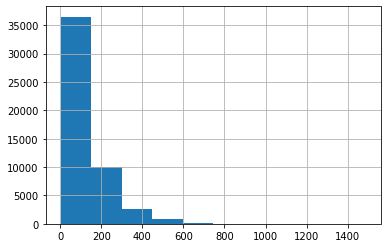

count    50000.000000
mean       130.815000
std         99.359444
min          3.000000
25%         69.000000
50%         97.000000
75%        160.000000
max       1486.000000
Name: len_review, dtype: float64

In [23]:
%matplotlib inline
pd.Series(df['len_review']).hist()
plt.show()
pd.Series(df['len_review']).describe()

In [24]:
review_int = df['review_int']
review_len = df['len_review']
review_label = df['sentiment']
review_int = [review_int[i] for i,x in enumerate(review_int) if review_len[i]>0]
review_label = [review_label[i] for i,x in enumerate(review_label) if review_len[i]>0]
review_len = [review_len[i] for i,x in enumerate(review_len) if review_len[i]>0 ]

In [25]:
len(review_int)

50000

In [26]:
def pad_features(review_int, L):
  features = np.zeros((len(review_int),L), dtype = int)
  for i,review in enumerate(review_int):
    l = len(review)
    if l <= L:
      patch = [0]*(L-l)
      new = patch + review
      features[i,:] = np.array(new)
    else :
      features[i,:] = np.array(review[:L])
  return features

In [27]:
features = pad_features(review_int, 200)

In [28]:
print(features[:10,:])

[[  0   0   0 ... 129  24 117]
 [  0   0   0 ... 197 138 154]
 [  0   0   0 ...  50 190 227]
 ...
 [  0   0   0 ... 404 258 213]
 [  0   0   0 ... 556 561 562]
 [  0   0   0 ...  66 165 571]]


In [29]:
split_frac = 0.8

train_x = features[0:int(len(features)*split_frac)]
train_y = np.array(review_label[0:int(len(features)*split_frac)])

test_x = features[len(features)-int(len(features)*split_frac):len(features)-int(len(features)*split_frac/2)]
test_y = np.array(review_label[len(features)-int(len(features)*split_frac):len(features)-int(len(features)*split_frac/2)])

valid_x = features[len(features)-int(len(features)*split_frac/2):]
valid_y = np.array(review_label[len(features)-int(len(features)*split_frac/2):])

In [30]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [31]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,  9588,   276,  ..., 19458,  1212,   537],
        [  433, 59485,   142,  ...,   589,    78,   792],
        [    0,     0,     0,  ...,   610,   889,   610],
        ...,
        [    0,     0,     0,  ...,   164,   278,   278],
        [    0,     0,     0,  ...,   129, 10873,   347],
        [    0,     0,     0,  ...,  1650,   581,  1058]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1])


# Model 

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [33]:
class SentimentGRU(nn.Module):
    """
    The GRU model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and GRU layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
  
        # embeddings and gru_out
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)
    
        # stack up gru outputs
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
        

In [34]:
# Instantiate the model w/ hyperparams
vocab_size = len(review_dict)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentGRU(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentGRU(
  (embedding): Embedding(132057, 400)
  (gru): GRU(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [35]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [36]:
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [37]:
# training params

epochs = 10

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1
        #print(counter)
       
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = h.data
        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in GRUs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = h.data

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/10... Step: 100... Loss: 0.518918... Val Loss: 0.542816
Epoch: 1/10... Step: 200... Loss: 0.485150... Val Loss: 0.480546
Epoch: 1/10... Step: 300... Loss: 0.466430... Val Loss: 0.446623
Epoch: 1/10... Step: 400... Loss: 0.323291... Val Loss: 0.364107
Epoch: 1/10... Step: 500... Loss: 0.311293... Val Loss: 0.327721
Epoch: 1/10... Step: 600... Loss: 0.434453... Val Loss: 0.319930
Epoch: 1/10... Step: 700... Loss: 0.224463... Val Loss: 0.284476
Epoch: 1/10... Step: 800... Loss: 0.309401... Val Loss: 0.264204
Epoch: 2/10... Step: 900... Loss: 0.400234... Val Loss: 0.293575
Epoch: 2/10... Step: 1000... Loss: 0.159939... Val Loss: 0.263725
Epoch: 2/10... Step: 1100... Loss: 0.224445... Val Loss: 0.259456
Epoch: 2/10... Step: 1200... Loss: 0.244297... Val Loss: 0.236402
Epoch: 2/10... Step: 1300... Loss: 0.205482... Val Loss: 0.232698
Epoch: 2/10... Step: 1400... Loss: 0.179387... Val Loss: 0.211641
Epoch: 2/10... Step: 1500... Loss: 0.448683... Val Loss: 0.213592
Epoch: 2/10... Step

In [38]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = h.data

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.005
Test accuracy: 99.870%


In [39]:
def preprocess(review):
    review = review.lower()
    word_list = review.split()
    num_list = []
    #list of reviews
    #though it contains only one review as of now
    reviews_int = []
    for word in word_list:
        if word in review_dict.token2id:
            num_list.append(review_dict.token2id[word])
    reviews_int.append(num_list)
    return reviews_int

In [40]:
def predict(net, test_review, sequence_length=200):
    ''' Prints out whether a give review is predicted to be 
        positive or negative in sentiment, using a trained model.
        
        params:
        net - A trained net 
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''
    #change the reviews to sequence of integers
    int_rev = preprocess(test_review)
    #pad the reviews as per the sequence length of the feature
    features = pad_features(int_rev, L=seq_length)
    
    #changing the features to PyTorch tensor
    features = torch.from_numpy(features)
    
    #pass the features to the model to get prediction
    net.eval()
    val_h = net.init_hidden(1)
    val_h = val_h.data

    if(train_on_gpu):
        features = features.cuda()

    output, val_h = net(features, val_h)
    
    #rounding the output to nearest 0 or 1
    pred = torch.round(output)
    
    #mapping the numeric values to postive or negative
    sent = ["Positive" if pred.item() == 1 else "Negative"]
    
    # print custom response based on whether test_review is pos/neg
    print(sent,'  ',((pred.item()==1)*output.item()+(pred.item()==0)*(1-output.item()))*100,'%')

In [41]:
positive_review = 'A great movie. Totally worth every penny. '

In [42]:
seq_length=200
predict(net, positive_review, seq_length)

['Positive']    99.8462438583374 %


In [43]:
negative_review = 'Amongst the worst works of diresctor nick furry. I want my money back. Waste of time.'

In [44]:
seq_length=200
predict(net, negative_review, seq_length)

['Negative']    99.99750007955299 %


In [45]:
predict(net,'waste',sequence_length=200)

['Negative']    82.7198475599289 %


In [46]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in valid_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = h.data

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(valid_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.304
Test accuracy: 93.760%
